![MOSEK ApS](https://www.mosek.com/static/images/branding/webgraphmoseklogocolor.png )

# Linear Regression techniques using MOSEK Fusion API


Regression is one of the most used techniques in finance, statistic, biology and in general any application where it is necessary to construct models that approximate input data.

The aim of this tutorial is two-fold:

1. to show some modeling techniques to define regression problems;
2. to show how to efficiently implement those problems using MOSEK Fusion API.


This tutorial is largerly based on:

    [1] Schmelzer, T., Hauser, R., Andersen, E., & Dahl, J. (2013). Regression techniques for Portfolio Optimisation using MOSEK. arXiv preprint arXiv:1310.3397.
    [2] Boyd, S., & Vandenberghe, L. (2004). Convex optimization. Cambridge university press.


The code is written in Python3 and uses the [MOSEK Fusion API](https://mosek.com/documentation).

In [1]:
import mosek
from mosek.fusion import *
print("MOSEK version", mosek.Env.getversion())

MOSEK version (9, 0, 40)


# The basics of linear regression

A linear model is used to explain the relation between $m$ input variables $x_1,\ldots,x_m$ and a dependent variable $y$ (the output). To this extent we assume that there exists a set of weights $w\in \mathbb{R}^{m}$ such that ideally

$$
y = x^T w,
$$

where $x=(x_1,\ldots,x_m)$.

In practice, we are given $n$ observations of the relation that links $x$ and $y$. We store them row-wise in a matrix $X\in \mathbb{R}^{n\times m}$. Corresponding outputs $y=(y_i,\ldots,y_n)$ are known as well. If the relation we want to describe is truly linear we can hope to solve the linear system

$$
X w =y.
$$

But usually this is not the case and we can only settle for an approximation which minimizes (in some sense) the residual vector

$$
r = Xw - y,
$$

and we obtain an optimization problem

$$
\begin{array}{ll}
 \mbox{minimize} & \phi(r)\\ 
  s.t. & r = Xw - y, \\
       & w\in W.
\end{array}
$$

The choice of the cost function $\phi(\cdot)$ determines the way errors on the residuals are weighted. Here we demonstrate the following variants:

* $\ell_2$-norm,
* $\ell_1$-norm,
* $\ell_p-$norm ,
* *Chebyshev* norm (also known as *Min-max*),
* *Deadzone-linear*,
* *$k$-largest residuals*.

We create simple input data sets which attempt to lead to the solution $w=(1,\ldots,1)$ and we add small normally distributed error as follows.

In [2]:
import numpy as np
import sys
%matplotlib inline
import matplotlib.pyplot as plt

def dataset(m, n):
    X = np.random.uniform(-1.0, 1.0, (n,m))
    y = X.dot(np.ones(m)) + np.random.normal(0.0, 0.2, n)
    return X, y

## $\ell_2$-norm

The regression problem with respect to the $\ell_2$-norm (i.e. linear least squares) has the conic quadratic formulation

$$
\begin{array}{ll}
\mbox{minimize} & t\\
\mbox{s.t.} & t\geq \|Xw-y\|_2 \quad \mathrm{i.e.}\ (t,Xw-y)\in \mathcal{Q}^{n+1},\\
 & t\in\mathbb{R}, w\in\mathbb{R}^m.
\end{array}
$$

This model models the maximum likelihood of the fit precisely under the assumption that residuals have normal distribution.

Below is the model in Fusion.            

In [3]:
def l2norm(X,y):
    n,m=X.shape
    
    M = Model("l2norm")
    w = M.variable(m)
    t = M.variable()
    
    M.objective(ObjectiveSense.Minimize, t)
    
    res = Expr.sub(Expr.mul(X,w), y)
    M.constraint(Expr.vstack(t, res), Domain.inQCone())
    
    #M.setLogHandler(sys.stdout)
    M.solve()
    
    # Return the weights vector and the residuals
    w = w.level()
    return w, X.dot(w)-y

X,y = dataset(10,1000)
w, res = l2norm(X,y)

If everything went well, we should have recovered the weight vector of all ones and normally distributed residuals, as below:

|w-1|_2: 0.025785996710141198


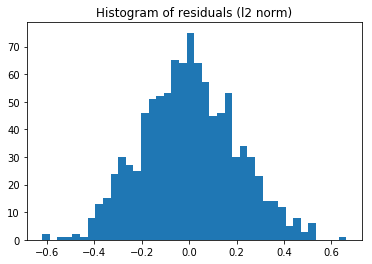

In [4]:
print("|w-1|_2:", np.linalg.norm(w-np.ones(10)))
plt.hist(res,40)
plt.title("Histogram of residuals (l2 norm)")
plt.show()

## $\ell_1$-norm

Under the $\ell_1$-norm we minimize $\sum_i |r_i|$. The corresponding linear formulation is

$$
\begin{array}{ll}
\mbox{minimize}  & \sum_i t_i \\
\mbox{s.t.} & t\geq Xw-y,\\
 & t \geq -(Xw-y), \\
 & w\in\mathbb{R}^m, t\in\mathbb{R}^n,
\end{array}
$$ 

which simply expresses the bound $t_i\geq |r_i|$. Below is a corresponding Fusion model.

|w-1|_2: 0.034229179355081116


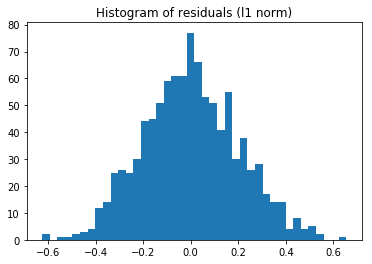

In [5]:
def l1norm(X,y):
    n,m=X.shape
    
    M = Model("l1norm")
    w = M.variable(m)
    t = M.variable(n)
    
    M.objective(ObjectiveSense.Minimize, Expr.sum(t))
    
    res = Expr.sub(Expr.mul(X,w), y)
    M.constraint(Expr.sub(t, res), Domain.greaterThan(0))
    M.constraint(Expr.add(t, res), Domain.greaterThan(0))
    
    #M.setLogHandler(sys.stdout)
    M.solve()
    
    # Return the weights vector and the residuals
    w = w.level()
    return w, X.dot(w)-y

w, res = l1norm(X,y)
print("|w-1|_2:", np.linalg.norm(w-np.ones(10)))
plt.hist(res,40)
plt.title("Histogram of residuals (l1 norm)")
plt.show()

## $\ell_p$-norm

The $\ell_p$ norm

$$\phi(r) = \| r \|_p = \left( \sum_i |r_i|^p \right)^{1/p}$$

For a general $p>1$ we can model it using the power cone. The standard representation of the epigraph $t\geq\|r\|_p$ as a conic model can be found in https://docs.mosek.com/modeling-cookbook/powo.html#norm-cones

$$
\begin{array}{l}
\sum_i s_i = t\\
s_it^{p-1} \geq |r_i|^p, \ i=1,\ldots,n
\end{array}
$$

and the last constraint can be expressed using a power cone. In Fusion all of these individual conic constraints can be specified at once in matrix for, where, as always in Fusion, "matrix in a cone" is a shorthand for "each row of the matrix is in the cone".

|w-1|_2: 0.025786431917413328


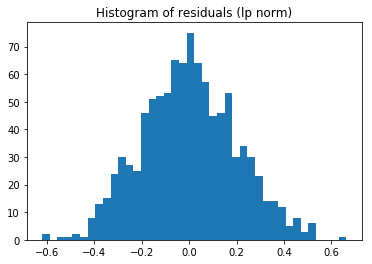

In [6]:
def lpnorm(X,y,p):
    n,m=X.shape
    
    M = Model("lpnorm")
    w = M.variable(m)
    t = M.variable()
    s = M.variable(n)
    
    M.objective(ObjectiveSense.Minimize, t)
    
    M.constraint(Expr.sub(Expr.sum(s),t), Domain.equalsTo(0))
    
    res = Expr.sub(Expr.mul(X,w), y)
    M.constraint(Expr.hstack(s, Var.repeat(t,n), res), Domain.inPPowerCone(1.0/p))
    
    #M.setLogHandler(sys.stdout)
    M.solve()

    # Return the weights vector and the residuals
    w = w.level()
    return w, X.dot(w)-y

w, res = lpnorm(X,y,p=2)
print("|w-1|_2:", np.linalg.norm(w-np.ones(10)))
plt.hist(res,40)
plt.title("Histogram of residuals (lp norm)")
plt.show()

# Deadzone-linear

This approach steams from the $\ell_1$ norm approximation, but ignoring small errors. Given a threshold $a\geq 0$, we define 

$$ \phi(r) = \sum_i \max(0, |r_i|-a )$$

The conic optimization model takes the form:

$$
\begin{array}{ll}
\mbox{minimize} &  \sum_i t_i\\
\mbox{s.t.} & t \geq |Xw-y|-a,\\
& t\geq 0 
\end{array}
$$ 

Again, removing the absolute value we obtain in compact form:

$$
\begin{array}{ll}
\mbox{minimize} &  \sum_i t_i\\
\mbox{s.t.} & t \geq Xw-y-a,\\
  & t \geq -(Xw-y)-a,\\
& t\geq 0.
\end{array}
$$ 

|w-1|_2: 0.03798164802353423


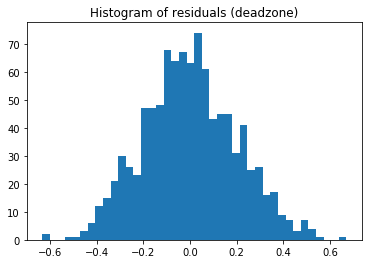

In [7]:
def deadzone(X,y,a):
    n,m=X.shape
    
    M = Model("deadzone")
    w = M.variable(m)
    t = M.variable(n, Domain.greaterThan(0))
    
    M.objective(ObjectiveSense.Minimize, Expr.sum(t))
    
    res = Expr.sub(Expr.mul(X,w), y)
    M.constraint(Expr.sub(t, res), Domain.greaterThan(-a))
    M.constraint(Expr.add(t, res), Domain.greaterThan(-a))
    
    #M.setLogHandler(sys.stdout)
    M.solve()
    
    # Return the weights vector and the residuals
    w = w.level()
    return w, X.dot(w)-y

w, res = deadzone(X,y,0.05)
print("|w-1|_2:", np.linalg.norm(w-np.ones(10)))
plt.hist(res,40)
plt.title("Histogram of residuals (deadzone)")
plt.show()

## Chebyshev Approximation

Sometimes referred as the *minmax* approximation, it uses 

$$\phi(r) = \max_i( |r_i| ) = \|r\|_{\infty}$$

as penalty function. It is a limit case of $\ell_p-$norms as $p\rightarrow \infty$. The effect is to only look at the largest error in absolute value. The formulation of our problem is therefore

$$
\begin{array}{ll}
\mbox{minimize} & t\\
\mbox{s.t.} & te \geq Xw-y,\\
  & te \geq -(Xw-y),
\end{array}
$$ 
where $e$ is the all-ones vector.

|w-1|_2: 0.16455126712218598


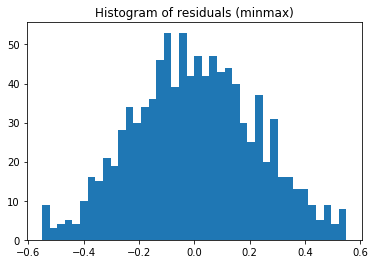

In [8]:
def minmax(X,y):
    n,m=X.shape
    
    M = Model("minmax")
    w = M.variable(m)
    t = M.variable()
    
    M.objective(ObjectiveSense.Minimize, t)
    
    res = Expr.sub(Expr.mul(X,w), y)
    t_repeat = Var.repeat(t,n)
    M.constraint(Expr.sub(t_repeat, res), Domain.greaterThan(0))
    M.constraint(Expr.add(t_repeat, res), Domain.greaterThan(0))
    
    #M.setLogHandler(sys.stdout)
    M.solve()
    
    # Return the weights vector and the residuals
    w = w.level()
    return w, X.dot(w)-y

w, res = minmax(X,y)
print("|w-1|_2:", np.linalg.norm(w-np.ones(10)))
plt.hist(res,40)
plt.title("Histogram of residuals (minmax)")
plt.show()

## Sum of the largest $k$ residuals

The penalty function $\phi$ is defined as 

$$\phi(u) = \sum_{i=1}^k | r_{[i]} |, $$

where the notation $r_{[i]}$ indicates the $i$-th element of $r$ sorted. It means that the penalty depends on the $k$ largest (in absolute value) residuals. This is a generalization of the minmax norm, which here corresponds to $k=1$, and of the $\ell_1$-norm, which corresponds to $k=n$. As shown in https://docs.mosek.com/modeling-cookbook/linear.html#sum-of-largest-elements whis problem can be modeled in a linear fashion:

$$
\begin{array}{ll}
\mbox{minimize} & ks+\sum u_i\\
\mbox{s.t.} & se + u \geq Xw -y\\
            & se + u \geq -(Xw -y)\\
            & u\geq 0,\\
            & u\in \mathbb{R}^n,s\in \mathbb{R},w\in\mathbb{R}^m.
\end{array}
$$

|w-1|_2: 0.08698784890647508


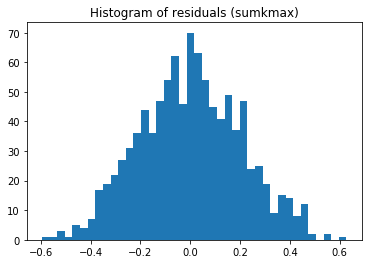

In [9]:
def sumkmax(X,y,k):
    n,m=X.shape
    
    M = Model("sumkmax")
    w = M.variable(m)
    s = M.variable()
    u = M.variable(n, Domain.greaterThan(0))
    
    M.objective(ObjectiveSense.Minimize, Expr.add(Expr.sum(u), Expr.mul(k,s)))
    
    res = Expr.sub(Expr.mul(X,w), y)
    lhs = Expr.add(u, Var.repeat(s,n))
    M.constraint(Expr.sub(lhs, res), Domain.greaterThan(0))
    M.constraint(Expr.add(lhs, res), Domain.greaterThan(0))
    
    #M.setLogHandler(sys.stdout)
    M.solve()
    
    # Return the weights vector and the residuals
    w = w.level()
    return w, X.dot(w)-y

w, res = sumkmax(X,y,20)
print("|w-1|_2:", np.linalg.norm(w-np.ones(10)))
plt.hist(res,40)
plt.title("Histogram of residuals (sumkmax)")
plt.show()

## Some observations

All the regression models presented in this tutorial lead to either a linear or a second-order cone or a power cone  optimization problem. That means that

* they can be solved in polynomial time by standard optimization algorithms;
* add additional (conic)constraints on the weights can be easily included;
* sparsity in the input, i.e. in $X$, can be easily handled and usually leads to great savings in time and memory;
* the solver will automatically choose between the primal and dual formulation;

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. The **MOSEK** logo and name are trademarks of <a href="http://mosek.com">Mosek ApS</a>. The code is provided as-is. Compatibility with future release of **MOSEK** or the `Fusion API` are not guaranteed. For more information contact our [support](mailto:support@mosek.com). 